# Age of Empires II Match Data Analysis - Part 2

Analyzing civilization performance across player skill levels (ELO ratings) to uncover how meta shifts between different brackets.

## Data Preparation

Segmenting players into four ELO brackets:

- **Low**: <1000 ELO - Newer players
- **Medium**: 1000-1250 ELO - Intermediate players
- **High**: 1250-1650 ELO - Advanced players
- **Pro**: >1650 ELO - Expert players

## Visualization Approach

Using grouped bar charts with:
- Color-coding by ELO bracket
- Direct civilization labels on bars
- 50% reference line for balanced win rate

## Arabia Map Analysis by ELO Bracket

Arabia is the most popular competitive map with open terrain and limited natural defenses. This analysis shows top civilizations by player skill level.

# Age of Empires II Match Data Analysis - Part 2

This notebook continues our analysis of Age of Empires II match data, focusing on how civilization performance varies across different player skill levels (ELO brackets). We'll segment players into skill brackets using K-means clustering and analyze civilization win rates for each bracket.

In [71]:
# some imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans


# load the data
df = pd.read_csv('aoe_data.csv')

# drop match uid -- not needed for analysis
df = df.drop(columns=['Unnamed: 0'])

## Data Preparation

We'll start by loading our Age of Empires II match data and performing initial preparations. The dataset contains information about matches including player ELO ratings, civilizations used, map types, and match outcomes.

In [72]:
df.sample(3)

,match_id,map,map_size,duration,dataset,difficulty,elo,p1_civ,p2_civ,p1_xpos,p2_xpos,p1_ypos,p2_ypos,winner
99193,84923645,Arena,Tiny,2497,Definitive Edition,Hardest,936.0,Tatars,Huns,96.0,61.0,86.0,15.0,1
54171,112742707,Arabia,Tiny,3404,Definitive Edition,Hardest,1024.0,Vikings,Berbers,20.0,85.0,62.0,30.0,1
121862,136975929,Arabia,Tiny,3030,Definitive Edition,Hardest,1282.5,Magyars,Britons,52.0,80.0,19.0,94.0,1


The dataset contains match information including:
- Player ELO ratings - representing skill level
- Civilizations used by each player
- Map type (Arabia, Arena, etc.)
- Match winner (1 for player 1, 0 for player 2)
- Duration and other match details

Last time we saw what civs excelled on arabia and arena and the results were not quite what we expected with Portugese and Italians topping Arabia and Magyars and Tartars topping Arena
Let's see if we ccan do some splitting via elo 

In [73]:
elo_values = df[['elo']].dropna()
kmeans = KMeans(n_clusters=4, random_state=42).fit(elo_values)
df['elo_bracket'] = kmeans.labels_


## Segmenting Players by Skill Level

To understand how civilization performance varies across different skill levels, we'll use K-means clustering to divide players into 4 distinct ELO brackets. This unsupervised learning approach will help us identify natural groupings in the player skill distribution.

In [74]:
df

,match_id,map,map_size,duration,dataset,difficulty,elo,p1_civ,p2_civ,p1_xpos,p2_xpos,p1_ypos,p2_ypos,winner,elo_bracket
0,50453403,Arabia,Tiny,3445,Definitive Edition,Hardest,1104.0,Vikings,Mayans,92.0,24.0,37.0,78.0,0,3
1,118982970,Arena,Tiny,2932,Definitive Edition,Hardest,884.5,Britons,Goths,70.0,82.0,16.0,98.0,0,0
2,57185801,Arena,Tiny,2573,Definitive Edition,Hardest,905.5,Chinese,Malians,69.0,61.0,16.0,104.0,0,0
3,64335748,Arabia,Tiny,851,Definitive Edition,Hardest,1080.0,Mayans,Magyars,25.0,98.0,80.0,68.0,1,3
4,116883036,Arabia,Tiny,4737,Definitive Edition,Hardest,1050.0,Berbers,Slavs,83.0,30.0,28.0,85.0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224594,137272191,Arabia,Tiny,2525,Definitive Edition,Hardest,1540.0,Mongols,Byzantines,19.0,98.0,53.0,54.0,1,2
224595,114000000,Nomad,Tiny,3208,Definitive Edition,Hardest,1066.0,Berbers,Ethiopians,NaN,NaN,NaN,NaN,0,3
224596,124942713,Arabia,Tiny,4243,Definitive Edition,Hardest,870.5,Bulgarians,Ethiopians,101.0,40.0,56.0,20.0,1,0
224597,141486159,Arabia,Tiny,3280,Definitive Edition,Hardest,1234.5,Turks,Indians,24.0,99.0,78.0,55.0,1,3


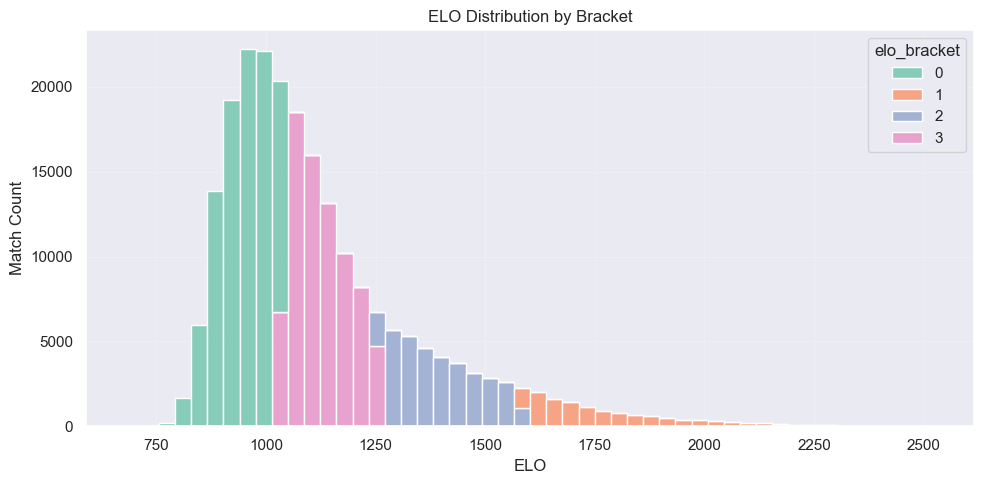

In [75]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='elo', hue='elo_bracket', bins=50, palette='Set2', multiple='stack')
plt.title("ELO Distribution by Bracket")
plt.xlabel("ELO")
plt.ylabel("Match Count")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


Let's visualize the distribution of player ELO ratings colored by the clusters identified by K-means. This will help us understand how our algorithm has segmented the player base.

In [76]:
bracket_map = {
    0: "Low",
    1: "Pro",
    2: "High",
    3: "Medium"
}

df['elo_bracket'] = df['elo_bracket'].map(bracket_map)


Based on ELO distribution, we assign labels:
- Cluster 0: "Low" ELO (beginners)
- Cluster 3: "Medium" ELO (intermediate)
- Cluster 2: "High" ELO (advanced)
- Cluster 1: "Pro" ELO (expert level)

In [77]:
# let's now determine top civs for arabia by elo bracket
# start by filtering for Arabia map
arabia_df = df[df['map'] == 'Arabia']

# group by elo bracket and civilization, then count matches
p1 = arabia_df[['elo_bracket', 'p1_civ', 'winner']].copy()
p1['civ'] = p1['p1_civ']
p1['win'] = p1['winner'] == 1

p2 = arabia_df[['elo_bracket', 'p2_civ', 'winner']].copy()
p2['civ'] = p2['p2_civ']
p2['win'] = p2['winner'] == 0  # p2 wins when winner == 0

# Combine
civs = pd.concat([p1[['elo_bracket', 'civ', 'win']], p2[['elo_bracket', 'civ', 'win']]])

agg = civs.groupby(['elo_bracket', 'civ'])['win'].agg(['sum', 'count']).reset_index()
agg['win_rate'] = agg['sum'] / agg['count'] * 100

top2 = agg.sort_values(['elo_bracket', 'win_rate'], ascending=[True, False]).groupby('elo_bracket').head(2)


## Civilization Performance Analysis by ELO Bracket

Analyzing top civilizations on Arabia across skill levels.

In [106]:
display(top2)

,elo_bracket,civ,sum,count,win_rate
29,High,Portuguese,280,476,58.823529
20,High,Koreans,340,590,57.627119
68,Low,Portuguese,477,806,59.181141
56,Low,Italians,564,971,58.084449
107,Medium,Portuguese,426,753,56.573705
95,Medium,Italians,488,889,54.893138
134,Pro,Italians,161,267,60.299625
150,Pro,Spanish,195,334,58.383234


Table showing top 2 civilizations per ELO bracket with match count, wins, and win rate percentage.

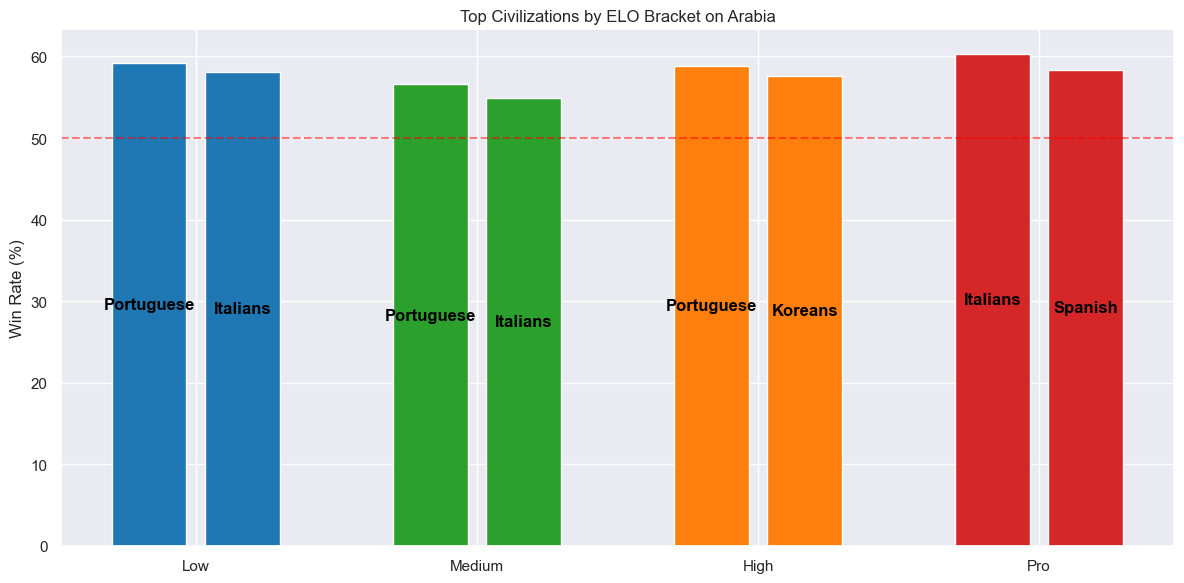

In [105]:
# Define the order of brackets we want
bracket_order = ["Low", "Medium", "High", "Pro"]

# Define the order of brackets we want
bracket_order = ["Low", "Medium", "High", "Pro"]

# Simple grouped barplot with colored brackets
plt.figure(figsize=(12, 6))

# Create a color map for brackets
bracket_colors = {
    "Low": "#1f77b4",     # Blue
    "Medium": "#2ca02c",  # Green
    "High": "#ff7f0e",    # Orange
    "Pro": "#d62728"      # Red
}

# Create the plot
x_pos = []
win_rates = []
colors = []
labels = []

x = 0
for bracket in bracket_order:
    bracket_data = top2[top2['elo_bracket'] == bracket]
    
    # Add each civ bar for this bracket
    for idx, row in bracket_data.iterrows():
        x_pos.append(x)
        win_rates.append(row['win_rate'])
        colors.append(bracket_colors[bracket])
        labels.append(row['civ'])
        x += 1
    
    # Add gap between brackets
    x += 1

# Plot bars
plt.bar(x_pos, win_rates, color=colors)

# Add civ names directly above the bars
for i, (pos, rate, label) in enumerate(zip(x_pos, win_rates, labels)):
    plt.text(pos, rate/2, label, ha='center', va='center', color='black', fontweight='bold')

# Add bracket labels
bracket_pos = []
last_pos = 0
for i, bracket in enumerate(bracket_order):
    count = len(top2[top2['elo_bracket'] == bracket])
    middle_pos = last_pos + (count - 1)/2
    bracket_pos.append(middle_pos)
    last_pos += count + 1

plt.xticks(bracket_pos, bracket_order)
plt.ylabel('Win Rate (%)')
plt.title('Top Civilizations by ELO Bracket on Arabia')
plt.axhline(y=50, color='red', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Visualization of Top Civilizations

Bar chart showing top civilizations by ELO bracket. Red line at 50% indicates balanced win rate.

## Conclusion and Future Analysis

### Key Findings:
1. **Different Meta by Skill Level**: Top civilizations vary across ELO brackets
2. **Skill-Dependent Civilizations**: Some civilizations require more expertise to use effectively
3. **Win Rate Variations**: Civilization choice matters more at lower ELO levels

### Future Analysis Ideas:
1. **Build Order Analysis**: Compare strategies across skill levels
2. **Map-Specific Strategies**: Extend to other popular maps
3. **Unit Composition Analysis**: Study unit preferences by skill level
4. **Team Game Analysis**: Identify civilization synergies